In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root, fixed_point
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load Training Data

filename = "/home/smalani/Cybernetic_BioModel/optogenetic_model_fits/June152023Onwards/trainingData/SGy139_TimeCourse_Jun9_23.xlsx"
df_br1 = pd.read_excel(filename, sheet_name="Bioreactor1")
df_br2 = pd.read_excel(filename, sheet_name="Bioreactor2")

df_br1.head()

,BatchTime,Phase,GrowthRate
0,0.000000,0.05,0.022972
1,0.016667,0.05,0.043676
2,0.033333,0.05,0.043676
3,0.050000,0.05,0.061904
4,0.066667,0.05,0.061904


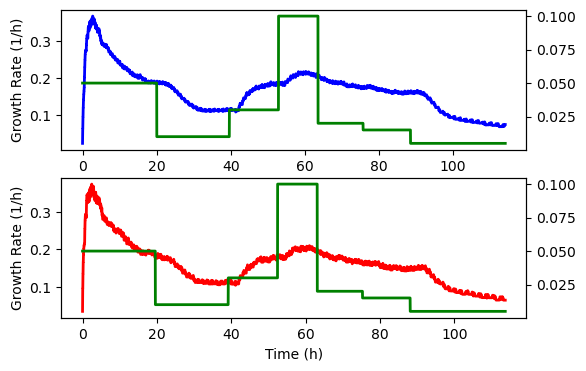

In [3]:
# Visualize Training Data

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(211)
ax.plot(df_br1["BatchTime"], df_br1["GrowthRate"], linewidth=2, color="blue", label="Bioreactor 1")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br1["BatchTime"], df_br1["Phase"], linewidth=2, color="green", label="Bioreactor 1")

ax = fig.add_subplot(212)
ax.plot(df_br2["BatchTime"], df_br2["GrowthRate"], linewidth=2, color="red", label="Bioreactor 2")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br2["BatchTime"], df_br2["Phase"], linewidth=2, color="green", label="Bioreactor 2")

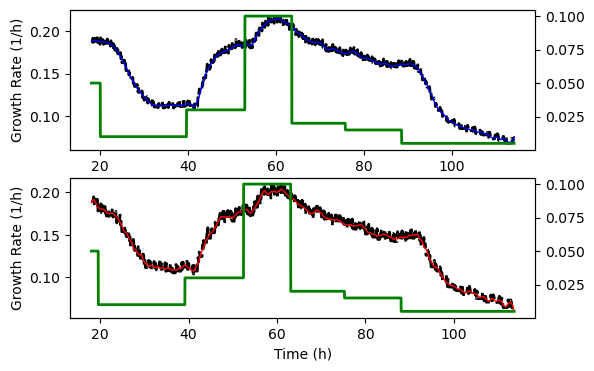

In [4]:
# Truncate and Smooth Data
from scipy.signal import savgol_filter

# Truncate data to remove initial lag phase
time_cutoff = 18
df_br1_trunc = df_br1[df_br1["BatchTime"] > time_cutoff].copy()
df_br2_trunc = df_br2[df_br2["BatchTime"] > time_cutoff].copy()

# Smooth data using Savitzky-Golay filter
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
# Parameters
window_size = 151
poly_order = 3
deriv = 0
df_br1_trunc["GrowthRateSmooth"] = savgol_filter(df_br1_trunc["GrowthRate"], window_size, poly_order, deriv=deriv)
df_br2_trunc["GrowthRateSmooth"] = savgol_filter(df_br2_trunc["GrowthRate"], window_size, poly_order, deriv=deriv)

# Visualize truncated and smoothed data
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(211)
ax.plot(df_br1_trunc["BatchTime"], df_br1_trunc["GrowthRate"], '--', linewidth=2, color="black", label="Bioreactor 1 (Raw)")
ax.plot(df_br1_trunc["BatchTime"], df_br1_trunc["GrowthRateSmooth"], linewidth=1, color="blue", label="Bioreactor 1")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br1_trunc["BatchTime"], df_br1_trunc["Phase"], linewidth=2, color="green", label="Bioreactor 1")

ax = fig.add_subplot(212)
ax.plot(df_br2_trunc["BatchTime"], df_br2_trunc["GrowthRate"], '--', linewidth=2, color="black", label="Bioreactor 2 (Raw)")
ax.plot(df_br2_trunc["BatchTime"], df_br2_trunc["GrowthRateSmooth"], linewidth=1, color="red", label="Bioreactor 2")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br2_trunc["BatchTime"], df_br2_trunc["Phase"], linewidth=2, color="green", label="Bioreactor 2")

[0.005, 0.01, 0.015, 0.02, 0.03, 0.05, 0.1]
[0.0734547580486065, 0.11449916164970078, 0.16115651184315924, 0.17368609162895002, 0.1835650140137684, 0.18798828591981112, 0.2066117976456574]
[0.0010881118139570098, 0.00017922013821686667, 0.0001351855672608787, 0.00023040634511450214, 0.0003416015420552834, 9.79051449885469e-05, 0.0003940932568776185]
[0.06350886004033417, 0.11409157907206488, 0.14736955059094883, 0.1629574775336532, 0.1785494072864605, 0.18371385974925505, 0.194438254015791]
[0.0020202843944336297, 0.0005138569688471562, 0.00021633159036764683, 0.0003193719741695719, 0.00022387115608396834, 0.0006227661336243767, 0.0002279725263584661]


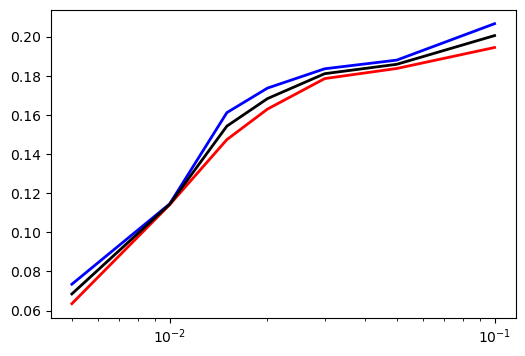

In [5]:
# Split dataframe by Phase

df_br1_trunc_grouped = df_br1_trunc.groupby("Phase")
df_br2_trunc_grouped = df_br2_trunc.groupby("Phase")

keys = list(df_br1_trunc_grouped.groups.keys())
print(keys)

mu_mean_br1 = []
mu_std_br1 = []
mu_mean_br2 = []
mu_std_br2 = []
mu_mean_overall = []
mu_std_overall = []

rangeme = 20

for key in keys:
    df = df_br1_trunc_grouped.get_group(key)
    mu_mean_br1.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    mu_std_br1.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())
    df = df_br2_trunc_grouped.get_group(key)
    mu_mean_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    mu_std_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())

    mu_mean_overall.append((mu_mean_br1[-1] + mu_mean_br2[-1])/2)
    mu_std_overall.append(np.sqrt(mu_std_br1[-1]**2 + mu_std_br2[-1]**2))
    

print(mu_mean_br1)
print(mu_std_br1)
print(mu_mean_br2)
print(mu_std_br2)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.semilogx(keys, mu_mean_br1, linewidth=2, color="blue", label="Bioreactor 1")
ax.semilogx(keys, mu_mean_br2, linewidth=2, color="red", label="Bioreactor 2")
ax.semilogx(keys, mu_mean_overall, linewidth=2, color="black", label="Overall")

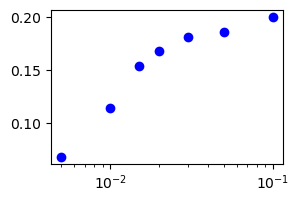

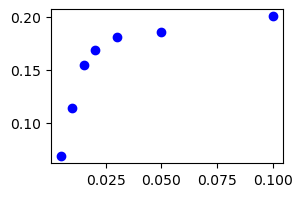

In [6]:
fig = plt.figure(figsize=(3, 2))
ax = fig.add_subplot(111)
ax.semilogx(keys, mu_mean_overall, 'o', linewidth=2, color="blue", label="Bioreactor 1")

fig = plt.figure(figsize=(3, 2))
ax = fig.add_subplot(111)
ax.plot(keys, mu_mean_overall, 'o', linewidth=2, color="blue", label="Bioreactor 1")

In [7]:
# Load Training Data

filename = "/home/smalani/Cybernetic_BioModel/optogenetic_model_fits/June152023Onwards/trainingData/SGy139_ActDeAct_Mar1_23.xlsx"
df_br1_actdeact = pd.read_excel(filename, sheet_name="Bioreactor1")
df_br2_actdeact = pd.read_excel(filename, sheet_name="Bioreactor2")

df_br1_actdeact.head()

,BatchTime,Phase,GrowthRate
0,0.000000,Batch_10%_1,0.021140
1,0.016667,Batch_10%_1,0.040492
2,0.033333,Batch_10%_1,0.040492
3,0.050000,Batch_10%_1,0.057788
4,0.066667,Batch_10%_1,0.057788


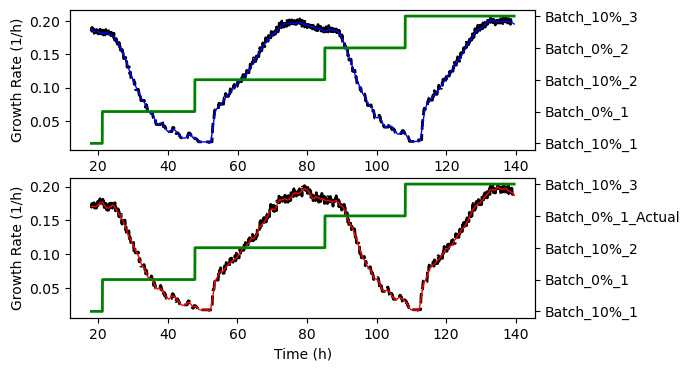

In [8]:
# Truncate and Smooth Data
from scipy.signal import savgol_filter

# Truncate data to remove initial lag phase
time_cutoff = 18
df_br1_trunc_actdeact = df_br1_actdeact[df_br1_actdeact["BatchTime"] > time_cutoff].copy()
df_br2_trunc_actdeact = df_br2_actdeact[df_br2_actdeact["BatchTime"] > time_cutoff].copy()

# Smooth data using Savitzky-Golay filter
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
# Parameters
window_size = 151
poly_order = 3
deriv = 0
df_br1_trunc_actdeact["GrowthRateSmooth"] = savgol_filter(df_br1_trunc_actdeact["GrowthRate"], window_size, poly_order, deriv=deriv)
df_br2_trunc_actdeact["GrowthRateSmooth"] = savgol_filter(df_br2_trunc_actdeact["GrowthRate"], window_size, poly_order, deriv=deriv)

# Visualize truncated and smoothed data
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(211)
ax.plot(df_br1_trunc_actdeact["BatchTime"], df_br1_trunc_actdeact["GrowthRate"], '--', linewidth=2, color="black", label="Bioreactor 1 (Raw)")
ax.plot(df_br1_trunc_actdeact["BatchTime"], df_br1_trunc_actdeact["GrowthRateSmooth"], linewidth=1, color="blue", label="Bioreactor 1")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br1_trunc_actdeact["BatchTime"], df_br1_trunc_actdeact["Phase"], linewidth=2, color="green", label="Bioreactor 1")

ax = fig.add_subplot(212)
ax.plot(df_br2_trunc_actdeact["BatchTime"], df_br2_trunc_actdeact["GrowthRate"], '--', linewidth=2, color="black", label="Bioreactor 2 (Raw)")
ax.plot(df_br2_trunc_actdeact["BatchTime"], df_br2_trunc_actdeact["GrowthRateSmooth"], linewidth=1, color="red", label="Bioreactor 2")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br2_trunc_actdeact["BatchTime"], df_br2_trunc_actdeact["Phase"], linewidth=2, color="green", label="Bioreactor 2")

[0.0734547580486065, 0.11449916164970078, 0.16115651184315924, 0.17368609162895002, 0.1835650140137684, 0.18798828591981112, 0.2066117976456574]
[0.0010881118139570098, 0.00017922013821686667, 0.0001351855672608787, 0.00023040634511450214, 0.0003416015420552834, 9.79051449885469e-05, 0.0003940932568776185]
[0.06350886004033417, 0.11409157907206488, 0.14736955059094883, 0.1629574775336532, 0.1785494072864605, 0.18371385974925505, 0.194438254015791]
[0.0020202843944336297, 0.0005138569688471562, 0.00021633159036764683, 0.0003193719741695719, 0.00022387115608396834, 0.0006227661336243767, 0.0002279725263584661]


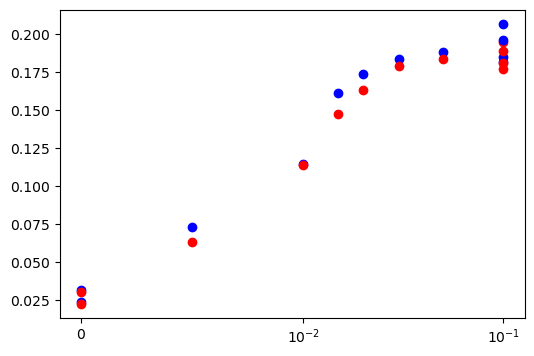

In [9]:
# Split dataframe by Phase

df_br1_trunc_actdeact_grouped = df_br1_trunc_actdeact.groupby("Phase")
df_br2_trunc_actdeact_grouped = df_br2_trunc_actdeact.groupby("Phase")

keys_br1_actdeact = list(df_br1_trunc_actdeact_grouped.groups.keys())
keys_br2_actdeact = list(df_br2_trunc_actdeact_grouped.groups.keys())

keys_add_br1 = []
keys_add_br2 = []


mu_mean_br1_actdeact = []
mu_std_br1_actdeact = []
mu_mean_br2_actdeact = []
mu_std_br2_actdeact = []

rangeme = 20

for key in keys_br1_actdeact:
    df = df_br1_trunc_actdeact_grouped.get_group(key)
    mu_mean_br1_actdeact.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    mu_std_br1_actdeact.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())
    # df = df_br2_trunc_actdeact_grouped.get_group(key)
    # mu_mean_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    # mu_std_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())

    if '_0%' in key:
        keys_add_br1.append(0)
    elif '_10%' in key:
        keys_add_br1.append(0.1)

for key in keys_br2_actdeact:
    df = df_br2_trunc_actdeact_grouped.get_group(key)
    mu_mean_br2_actdeact.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    mu_std_br2_actdeact.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())
    # df = df_br2_trunc_actdeact_grouped.get_group(key)
    # mu_mean_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    # mu_std_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())

    if '_0%' in key:
        keys_add_br2.append(0)
    elif '_10%' in key:
        keys_add_br2.append(0.1)

    

print(mu_mean_br1)
print(mu_std_br1)
print(mu_mean_br2)
print(mu_std_br2)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(keys, mu_mean_br1, 'o', linewidth=2, color="blue", label="Bioreactor 1")
ax.plot(keys, mu_mean_br2, 'o', linewidth=2, color="red", label="Bioreactor 2")
ax.plot(keys_add_br1, mu_mean_br1_actdeact, 'o', linewidth=2, color="blue", label="Bioreactor 1")
ax.plot(keys_add_br2, mu_mean_br2_actdeact, 'o', linewidth=2, color="red", label="Bioreactor 2")

ax.set_xscale('symlog', linthresh=0.01)

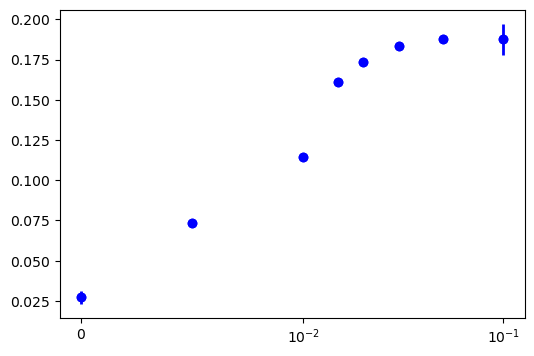

In [10]:
keys_plot = keys + keys_add_br1 + keys_add_br2
mu_plot = mu_mean_br1 + mu_mean_br1_actdeact + mu_mean_br2_actdeact
mu_plot = np.array(mu_plot)
keys_plot = np.array(keys_plot)

mu_plot = mu_plot[np.argsort(keys_plot)]
keys_plot = keys_plot[np.argsort(keys_plot)]

keys_unique = np.unique(keys_plot)
mu_unique = []
mu_std_unique = []

for key in keys_unique:
    mu_unique.append(mu_plot[keys_plot == key].mean())
    mu_std_unique.append(mu_plot[keys_plot == key].std())


fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(keys_unique, mu_unique, 'o', linewidth=2, color="blue", label="Bioreactor 1")
ax.errorbar(keys_unique, mu_unique, yerr=mu_std_unique, fmt='o', linewidth=2, color="blue", label="Bioreactor 1")
ax.set_xscale('symlog', linthresh=0.01)


In [11]:
from scipy.optimize import curve_fit, root

def myODEs(t, x, parameters, pulse):

    kE, kE_basal, nE, KE = parameters

    mu = x
    dxdt = kE_basal + kE * (pulse ** nE) / (pulse ** nE + KE ** nE) - (mu) * x
    return dxdt

In [12]:
# Interpolate more values for curve fit

keys_unique_interp = np.array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.03 , 0.05 , 0.08, 0.1  ])
mu_unique_interp = np.interp(keys_unique_interp, keys_unique, mu_unique)

In [13]:
from scipy.optimize import root, fixed_point

# Initial Guess
kE_basal = 0.001
kE = 0.03
KE = 0.01
nE = 4

time_delay = 3

parameters = [kE, kE_basal, nE, KE]

# Lambda function for steady state solution
f = lambda x, parameters, pulse: myODEs(0, x, parameters, pulse)

def pred_ss_fun(parameters, pulse_arr):
    pred_ss = []
    for pulse in pulse_arr:
        x_ss = root(f, 0.5, args=(parameters, pulse)).x
        pred_ss.append(x_ss)
    return np.array(pred_ss).flatten()


In [14]:
from scipy.interpolate import interp1d


def generate_predictions_multisetpoint(parameters, time_delay = 3):

    s = df_br1_trunc["Phase"]
    # time_array_fit = [df_br1_trunc["BatchTime"].iloc[0]]
    time_array_fit = []
    time_array_fit = np.append(time_array_fit, df_br1_trunc["BatchTime"][s[s.diff() != 0].index.tolist()])
    time_array_fit = np.append(time_array_fit, df_br1_trunc["BatchTime"].iloc[-1])
    time_array_fit[1:] += time_delay

    # pulse_array_fit = [df_br1_trunc["Phase"].iloc[0]]
    pulse_array_fit = []
    pulse_array_fit = np.append(pulse_array_fit, df_br1_trunc["Phase"][s[s.diff() != 0].index.tolist()])
    # pulse_array_fit = np.append(pulse_array_fit, df_br1_trunc["Phase"].iloc[-1])

    time_array_pred = []
    mu_array_pred = []

    x0 = np.array(pred_ss_fun(parameters, [pulse_array_fit[0]])).flatten()

    for i in range(len(time_array_fit)-1):
        pulse = pulse_array_fit[i]

        # print(pulse)
        # print(pulse_old)
        # print(R_ss)
        # print('====================')

        tspan = [time_array_fit[i], time_array_fit[i+1]]
        t_eval = np.linspace(tspan[0], tspan[1], 1000)
        
        sol = solve_ivp(myODEs, tspan, x0, method="BDF", t_eval=t_eval, args=(parameters, pulse), rtol=1e-3, atol=1e-6)
        x0 = sol.y[:,-1]

        mu = sol.y[-1,:]   

        time_array_pred = np.append(time_array_pred, sol.t)
        mu_array_pred = np.append(mu_array_pred, mu)

    time_array_pred = np.array(time_array_pred)
    mu_array_pred = np.array(mu_array_pred)

    return time_array_pred, mu_array_pred

def generate_predictions_actdeact(parameters, time_delay = 3):
    phase_df = df_br1_trunc_actdeact["Phase"].str.extract('_(.+)%_')[0].astype(float)/100
    s = phase_df
    # time_array_fit = [df_br1_trunc["BatchTime"].iloc[0]]
    time_array_fit_actdeact = []
    time_array_fit_actdeact = np.append(time_array_fit_actdeact, df_br1_trunc_actdeact["BatchTime"][s[s.diff() != 0].index.tolist()])
    time_array_fit_actdeact[1:] += time_delay
    time_array_fit_actdeact = np.append(time_array_fit_actdeact, df_br1_trunc_actdeact["BatchTime"].iloc[-1])

    # pulse_array_fit = [df_br1_trunc["Phase"].iloc[0]]
    pulse_array_fit_actdeact = []
    pulse_array_fit_actdeact = np.append(pulse_array_fit_actdeact, phase_df[s[s.diff() != 0].index.tolist()])

    x0 = np.array(pred_ss_fun(parameters, [pulse_array_fit_actdeact[0]])).flatten()

    time_array_pred = []
    mu_array_pred = []

    for i in range(len(time_array_fit_actdeact)-1):
        pulse = pulse_array_fit_actdeact[i]


        tspan = [time_array_fit_actdeact[i], time_array_fit_actdeact[i+1]]
        t_eval = np.linspace(tspan[0], tspan[1], 1000)
        
        sol = solve_ivp(myODEs, tspan, x0, method="BDF", t_eval=t_eval, args=(parameters, pulse), rtol=1e-6, atol=1e-9)
        x0 = sol.y[:,-1]

        mu = sol.y[-1,:]  

        time_array_pred = np.append(time_array_pred, sol.t)
        mu_array_pred = np.append(mu_array_pred, mu)

    time_array_pred = np.array(time_array_pred)
    mu_array_pred = np.array(mu_array_pred)

    return time_array_pred, mu_array_pred

def calculate_error(p, info):
    time_delay = p[0]
    pvar = p[1:]

    error = 0

    time_array_pred, mu_array_pred = generate_predictions_multisetpoint(pvar, time_delay)

    # interpolate to match time points
    mu_array_pred_interp = np.interp(df_br1_trunc["BatchTime"], time_array_pred, mu_array_pred)
    error_multisetpoint = np.mean((df_br1_trunc["GrowthRateSmooth"].to_numpy() - mu_array_pred_interp)**2)

    time_array_pred_actdeact, mu_array_pred_actdeact = generate_predictions_actdeact(pvar, time_delay)

    # interpolate to match time points
    mu_array_pred_interp_actdeact = np.interp(df_br1_trunc_actdeact["BatchTime"], time_array_pred_actdeact, mu_array_pred_actdeact)
    error_actdeact = np.mean((df_br1_trunc_actdeact["GrowthRateSmooth"].to_numpy() - mu_array_pred_interp_actdeact)**2)

    pred_ss = pred_ss_fun(pvar, keys_unique_interp)
    mu_ss = pred_ss 
    error_ss = np.mean((mu_ss - mu_unique_interp)**2)

    error = error_multisetpoint * 5 + error_actdeact + error_ss * 5

    if error < info['error_best']:
        info['error_best'] = error
        info['pars_best'] = p

    if info['Nfeval']%100 == 0:
        print('Nfeval: ', info['Nfeval'], 'error_best: ', info['error_best'], 'pars_best: ', info['pars_best'], 'error: ', error, 'pars: ', p)
    info['Nfeval'] += 1

    return error


In [15]:
kE_basal = 0.0009
kE = 0.035
KE = 0.01
nE = 4

time_delay = 3

parameters = [kE, kE_basal, nE, KE]

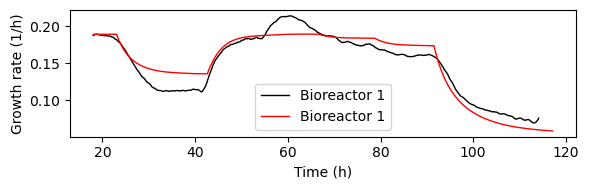

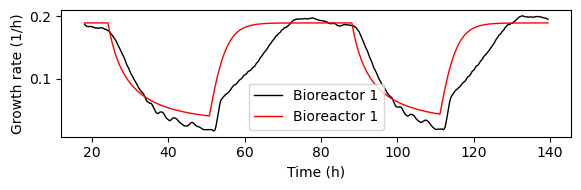

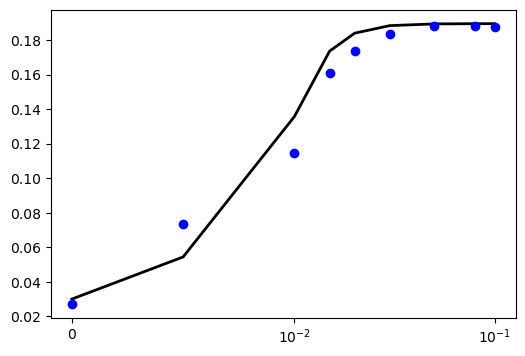

In [16]:
par_optimal = parameters

time_array_pred, mu_array_pred = generate_predictions_multisetpoint(par_optimal, time_delay)

fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(df_br1_trunc["BatchTime"].to_numpy(), df_br1_trunc["GrowthRateSmooth"], linewidth=1, color="black", label="Bioreactor 1")
ax.plot(time_array_pred, mu_array_pred, linewidth=1, color="red", label="Bioreactor 1")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth rate (1/h)")
ax.legend()
plt.tight_layout()

time_array_pred, mu_array_pred = generate_predictions_actdeact(par_optimal, time_delay)

fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(df_br1_trunc_actdeact["BatchTime"].to_numpy(), df_br1_trunc_actdeact["GrowthRateSmooth"], linewidth=1, color="black", label="Bioreactor 1")
ax.plot(time_array_pred, mu_array_pred, linewidth=1, color="red", label="Bioreactor 1")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth rate (1/h)")
ax.legend()
plt.tight_layout()

pred_ss = pred_ss_fun(par_optimal, keys_unique_interp)
mu_ss = pred_ss

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(keys_unique_interp, mu_ss, '-', linewidth=2, color="black", label="Model")
ax.plot(keys_unique_interp, mu_unique_interp, 'o', linewidth=2, color="blue", label="Data")
ax.set_xscale('symlog', linthresh=0.01)

In [17]:
# from scipy.optimize import basinhopping, differential_evolution, dual_annealing, minimize

# kE_basal = 0.0009
# kE = 0.035
# KE = 0.01
# nE = 4


# time_delay = 3

# parameters = [time_delay, kE, kE_basal, nE, KE]
# # parameters = info["pars_best"]

# bounds = [(0,10), (0, 10), (0, 10), (1e-5, 10), (1e-5, 10)]

# info = {'Nfeval':0, 'error_best': 1e10, 'pars_best': np.nan}

# # res = basinhopping(calculate_error, parameters, niter=1000, T=1, minimizer_kwargs={"method":"L-BFGS-B", "bounds":bounds, "args":(info,), "options":({"maxiter": 100})})
# class MyTakeStep(object):
#     def __init__(self, stepsize=0.05):
#         self.stepsize = stepsize

#     def __call__(self, x):
#         print('Stepping')
#         s = self.stepsize
#         x *= (1 + np.random.uniform(-s, s, x.shape))
#         return x
    
# res = basinhopping(calculate_error, parameters, niter=10000, T=1, minimizer_kwargs={"method":"L-BFGS-B", "bounds":bounds, "args":(info,), "options":({"maxiter": 100})}, take_step=MyTakeStep(stepsize=0.1))

# # res = minimize(calculate_error, parameters, method='L-BFGS-B', bounds=bounds, args=(info,))
# # res = differential_evolution(calculate_error, bounds, args=(info,), maxiter=10000, popsize=100, mutation=(0.5, 1), recombination=0.7, strategy='best1bin', tol=0.01, atol=0, seed=None, callback=None, disp=False, polish=True, init='latinhypercube')
# # res = dual_annealing(calculate_error, bounds, args=(info,), maxiter=10000, minimizer_kwargs={'method':'L-BFGS-B', 'bounds':bounds}, initial_temp=5230, restart_temp_ratio=2e-5, visit=2.62, accept=-5.0, maxfun=1e7, seed=None, no_local_search=False, callback=None, x0=parameters)

[4.36486878e+00 3.54996268e-02 5.92764941e-04 2.56241667e+00
 1.14559216e-02]


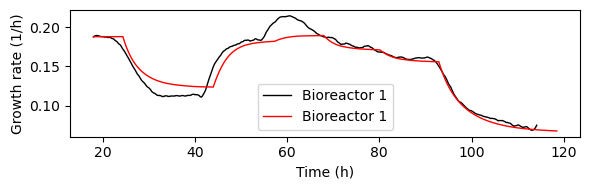

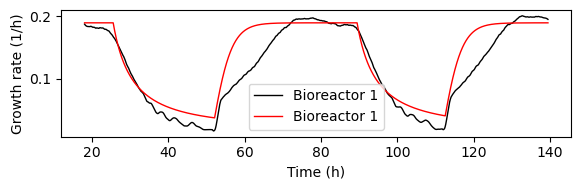

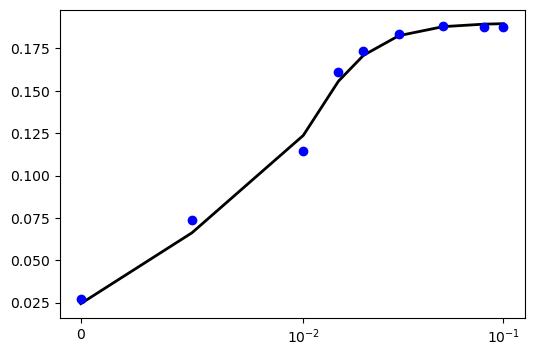

In [18]:
# parameters_to_use = info["pars_best"]
# parameters_to_use = np.array([4.54764697e+00, 1.26513506e-01, 2.96613612e-03, 2.60584110e+00,
#  1.12591190e-02, 8.93845149e-03, 2.90683086e-01])

parameters_to_use = np.array([4.36486878e+00, 3.54996268e-02, 5.92764941e-04, 2.56241667e+00,
 1.14559216e-02])
print(parameters_to_use)
# parameters_to_use = parameters

par_optimal = parameters_to_use[1:]
time_delay_optimal = parameters_to_use[0]

# error = calculate_error(parameters_to_use, info)

time_array_pred, mu_array_pred = generate_predictions_multisetpoint(par_optimal, time_delay_optimal)

fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(df_br1_trunc["BatchTime"].to_numpy(), df_br1_trunc["GrowthRateSmooth"], linewidth=1, color="black", label="Bioreactor 1")
ax.plot(time_array_pred, mu_array_pred, linewidth=1, color="red", label="Bioreactor 1")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth rate (1/h)")
ax.legend()
plt.tight_layout()

time_array_pred, mu_array_pred = generate_predictions_actdeact(par_optimal, time_delay_optimal)

fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(df_br1_trunc_actdeact["BatchTime"].to_numpy(), df_br1_trunc_actdeact["GrowthRateSmooth"], linewidth=1, color="black", label="Bioreactor 1")
ax.plot(time_array_pred, mu_array_pred, linewidth=1, color="red", label="Bioreactor 1")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth rate (1/h)")
ax.legend()
plt.tight_layout()

pred_ss = pred_ss_fun(par_optimal, keys_unique_interp)
mu_ss = pred_ss

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(keys_unique_interp, mu_ss, '-', linewidth=2, color="black", label="Model")
ax.plot(keys_unique_interp, mu_unique_interp, 'o', linewidth=2, color="blue", label="Data")
ax.set_xscale('symlog', linthresh=0.01)

In [19]:
from numpy import interp

df_pid = pd.read_excel("/home/smalani/Cybernetic_BioModel/optogenetic_model_fits/June152023Onwards/trainingData/SGy139_PID_Feb17_23.xlsx")
print(df_pid.head())

time_delay = time_delay_optimal - 1

time_arr = df_pid["time"].to_numpy()
mu_arr = df_pid["mu"].to_numpy()
pulse_arr = df_pid["u"].to_numpy()
pulse_arr_func = interp(time_arr-time_delay, time_arr, pulse_arr)

   time        mu       u
0   0.0  0.182910  0.1000
1   0.0  0.182910  0.0159
2   0.5  0.191892  0.0086
3   1.0  0.191750  0.0078
4   1.5  0.182703  0.0120


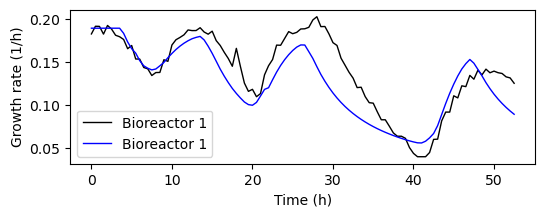

In [20]:
init_cond = pred_ss_fun(par_optimal, [pulse_arr[0]])
mu_arr_pred = np.zeros(len(pulse_arr))

mu_arr_pred[0] = init_cond

for i in range(1, len(pulse_arr)):
    tspan = [time_arr[i-1], time_arr[i]]
    pulse = interp(tspan[0]-time_delay, time_arr, pulse_arr)
    sol = solve_ivp(myODEs, tspan, init_cond, method="BDF", args=(par_optimal, pulse), rtol=1e-3, atol=1e-6)
    init_cond = sol.y[:,-1]
    mu_arr_pred[i] = sol.y[-1,-1]

fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(time_arr, mu_arr, linewidth=1, color="black", label="Bioreactor 1")
ax.plot(time_arr, mu_arr_pred, linewidth=1, color="blue", label="Bioreactor 1")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth rate (1/h)")
ax.legend()

In [21]:
mu_arr_pred.shape

(107,)